# Model Creation

After cleaning and getting a preliminary idea of the data, we're going to fit several models and evaluate them using the Mean Absolute Error (MAE). The models I'm going to try are:

* Linear Regression
* Ridge Regression
* Lasso Regression
* RandomForestRegressor

For the metrics, I'm also using the mean absolute error to tell a more concrete story of how well our model is performing. Instead of mean squared error, I used mean absolute error because we have several large outliers and I don't want our metric to be skewed by the large errors that'd be generated when we try to predict them using a model meant for typical revenue. It's also more interpretable, with the error returned simply being how many dollars, on average, we're off from the actual weekly revenue.

In [2]:
#Importing necessary modules
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
import pandas as pd
from statsmodels.formula.api import ols
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
import numpy as np
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm

## Reading in the original data

In [55]:
#Reading in the original test data
df = pd.read_csv(r'C:\Users\songs\Desktop\Springboard Files\Springboard-Files\Capstone 2\data\Interim\train_all_features.csv', 
                 index_col=0)
df.head()

,Store,Dept,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,...,Week_of_year,Day,Median_Sales,IsThanksgiving,IsChristmas,IsPreChristmas,Lagged_Value,Lag_Available,Diff_from_Med,IsDept72
106604,1,1,46039.49,True,38.51,2.548,0.0,0.0,0.0,0.0,...,6,12,19239.405,False,False,False,19239.405,False,0.000,False
106610,1,1,19403.54,False,46.63,2.561,0.0,0.0,0.0,0.0,...,8,26,19239.405,False,False,False,19239.405,False,0.000,False
106598,1,1,21827.90,False,46.50,2.625,0.0,0.0,0.0,0.0,...,9,5,19239.405,False,False,False,19403.540,True,164.135,False
106620,1,1,21043.39,False,57.79,2.667,0.0,0.0,0.0,0.0,...,10,12,19239.405,False,False,False,21827.900,True,2588.495,False
106607,1,1,57258.43,False,62.27,2.719,0.0,0.0,0.0,0.0,...,13,2,19239.405,False,False,False,19239.405,False,0.000,False


## Feature Selection

First, I'm going to see whether the logged revenue or the original revenue generates less error for each model. After finding that, I would then do feature selection to find the most important features for that particular model.

### Determining whether to use logged or unlogged values

In [56]:
#Creating Features and Target
X = df.drop(['Weekly_Sales','log_revenue'], axis=1).values
y_log = df['log_revenue'].values
y_not = df['Weekly_Sales'].values

As we're going to be doing this a lot, I wrote a function to split the data into training and testing set, fit the model (without any hyperparameter tuning), and evaluate the model.

In [57]:
#Function for creating training and testing dataset
def mean_abs_error(y,model):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    if (y == y_log).all():
        y_pred = np.exp(y_pred) - 4989.94
        y_true = np.exp(y_test)
    else:
        y_true = y_test
    return mean_absolute_error(y_true, y_pred)

#### Linear Regression

In [58]:
#Linear
linear = LinearRegression()

print("The mean absolute error calculated using the logged values is " + str(round(mean_abs_error(y_log,linear),2)))
print("The mean absolute error calculated using the original values is " + str(round(mean_abs_error(y_not,linear),2)))

The mean absolute error calculated using the logged values is 46431.79
The mean absolute error calculated using the original values is 2244.92


It's clear that the original values perform better. Next, we're going to test RandomForestRegressor. I didn't test Lasso and Ridge regression because they're very similar to Linear Regression, and the dataset that performs better for Linear Regression is likely to replicate its success for Lasso and Ridge Regression.

#### RandomForestRegressor

In [59]:
#RandomForestRegressor
rf = RandomForestRegressor()

print("The mean absolute error calculated using the logged values is " + str(round(mean_abs_error(y_log,rf),2)))
print("The mean absolute error calculated using the original values is " + str(round(mean_abs_error(y_not,rf),2)))

C:\Users\songs\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


The mean absolute error calculated using the logged values is 5482.54
The mean absolute error calculated using the original values is 1915.93


In both cases, it appears that we should predict using the original values as they generate the smaller MAE.

### RFE feature selector for Linear Regression model

Next, we're going to try to eliminate some of the extraneous features for Linear Regression and its relatives (Lasso and Ridge Regression). I didn't do this for RandomForestRegressor because it has a built-in feature that measures feature importance.

In [60]:
#Train Test Split on original revenue.
X_train, X_test, y_train, y_test = train_test_split(X, y_not, test_size=0.3)

First, we find the optimal number of features for our linear regression model, which we defined above (linear) when comparing prelimary results between logged and unlogged values.

In [61]:
#Total number of features
n_features = len(df.drop(['Weekly_Sales','log_revenue'], axis=1).columns)
options = np.arange(1,n_features)
low_score = 4000 #A number we're certainly going to be lower than
nof = 0

#Fitting model
for n in tqdm(range(len(options))):
    
    #Creating model
    rfe = RFE(linear, options[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    
    #Fitting model
    linear.fit(X_train_rfe,y_train)
    y_pred = linear.predict(X_test_rfe)
    score = mean_absolute_error(y_test, y_pred)
    if(score<low_score):
        low_score = score
        nof = options[n]
    
print(nof, round(low_score,2))


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [01:30<00:00,  2.24s/it]

25 2213.32


It appears that a linear regression model with 26 features performs the best, with a mean absolute error or 2215.84 dollars. That is 22 dollars less than our preliminary model without any feature selection, so it is an improvement. Now let's find out what those features are.

In [62]:
#Initializing RFE model and transforming the data with it.
rfe_linear = RFE(linear, nof)
X_rfe = rfe_linear.fit_transform(X_train,y_train)

#Fitting the data to model
linear.fit(X_rfe,y_train)

#Visualizing which ones are most important
cols = list(df.drop(['Weekly_Sales','log_revenue'],axis=1).columns)

temp = pd.Series(rfe_linear.support_,index = cols)
temp

Store              True
Dept               True
IsHoliday          True
Temperature        True
Fuel_Price         True
MarkDown1          True
MarkDown2          True
MarkDown3          True
MarkDown4         False
MarkDown5         False
CPI                True
Unemployment       True
Size              False
Type_A             True
Type_C             True
IsMarkDown         True
Year               True
Month              True
Week_of_year       True
Day                True
Median_Sales       True
IsThanksgiving     True
IsChristmas        True
IsPreChristmas     True
Lagged_Value       True
Lag_Available      True
Diff_from_Med      True
IsDept72           True
dtype: bool

As it apears, the size is not important for predicting the revenue generated. This is surprising, but perhaps the type attribute already covered information about size.

In [100]:
selected_features_rfe_linear = list(temp[temp==True].index)

#Creating and saving the resulting dataframe
df_linear = df[selected_features_rfe_linear]
df_linear_revenue = df_linear.join(df['Weekly_Sales'], how='outer')
df_linear_revenue.to_csv(r'C:\Users\songs\Desktop\Springboard Files\Springboard-Files\Capstone 2\data\Interim\original_train_linear.csv')
df_linear_revenue.head()

,Store,Dept,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,CPI,Unemployment,...,Day,Median_Sales,IsThanksgiving,IsChristmas,IsPreChristmas,Lagged_Value,Lag_Available,Diff_from_Med,IsDept72,Weekly_Sales
106604,1,1,True,38.51,2.548,0.0,0.0,0.0,211.242170,8.106,...,12,19239.405,False,False,False,19239.405,False,0.000,False,46039.49
106610,1,1,False,46.63,2.561,0.0,0.0,0.0,211.319643,8.106,...,26,19239.405,False,False,False,19239.405,False,0.000,False,19403.54
106598,1,1,False,46.50,2.625,0.0,0.0,0.0,211.350143,8.106,...,5,19239.405,False,False,False,19403.540,True,164.135,False,21827.90
106620,1,1,False,57.79,2.667,0.0,0.0,0.0,211.380643,8.106,...,12,19239.405,False,False,False,21827.900,True,2588.495,False,21043.39
106607,1,1,False,62.27,2.719,0.0,0.0,0.0,210.820450,7.808,...,2,19239.405,False,False,False,19239.405,False,0.000,False,57258.43


## Standardizing the data and finding PCA

For both the original dataset and the feature selected dataset, I'm going to standardize the features, do principal component analysis (PCA) on them, and compare the mean absolute error generated between the three datasets.

### Standardization

First, we're going to scale the **feature selected** data

In [125]:
#Standardizing the feature selected data
scaler = StandardScaler()

scaled_df_linear = scaler.fit_transform(df_linear)
scaled_df_linear = pd.DataFrame(scaled_df_linear)
scaled_df_linear = scaled_df_linear.join(df['Weekly_Sales'], how='outer')
scaled_df_linear.columns = df_linear_revenue.columns

#Saving the data
scaled_df_linear.to_csv(r'C:\Users\songs\Desktop\Springboard Files\Springboard-Files\Capstone 2\data\Interim\scaled_train_linear.csv')
scaled_df_linear.head()

,Store,Dept,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,CPI,Unemployment,...,Day,Median_Sales,IsThanksgiving,IsChristmas,IsPreChristmas,Lagged_Value,Lag_Available,Diff_from_Med,IsDept72,Weekly_Sales
0,-1.658029,-1.419057,3.640258,-1.171151,-1.771255,-0.428104,-0.171766,-0.083882,1.022305,0.073834,...,-0.419545,0.190542,-0.118986,-0.119551,-0.120143,0.158578,-1.381278,-0.092290,-0.120552,87235.57
1,-1.658029,-1.419057,-0.274706,-0.730958,-1.742908,-0.428104,-0.171766,-0.083882,1.024284,0.073834,...,1.180835,0.190542,-0.118986,-0.119551,-0.120143,0.158578,-1.381278,-0.092290,-0.120552,80254.53
2,-1.658029,-1.419057,-0.274706,-0.738006,-1.603354,-0.428104,-0.171766,-0.083882,1.025062,0.073834,...,-1.219735,0.190542,-0.118986,-0.119551,-0.120143,0.165984,0.723967,-0.063237,-0.120552,77715.58
3,-1.658029,-1.419057,-0.274706,-0.125964,-1.511771,-0.428104,-0.171766,-0.083882,1.025841,0.073834,...,-0.419545,0.190542,-0.118986,-0.119551,-0.120143,0.275378,0.723967,0.365888,-0.120552,83599.56
4,-1.658029,-1.419057,-0.274706,0.116900,-1.398383,-0.428104,-0.171766,-0.083882,1.011536,-0.085692,...,-1.562674,0.190542,-0.118986,-0.119551,-0.120143,0.158578,-1.381278,-0.092290,-0.120552,77876.10


First, we're going to scale the **not feature selected** data

In [65]:
#Standardizing the non-feature selected data
scaler = StandardScaler()

scaled_df = scaler.fit_transform(df.drop(['Weekly_Sales','log_revenue'],axis=1))
scaled_df = pd.DataFrame(scaled_df)
scaled_df.columns = df.drop(['Weekly_Sales','log_revenue'],axis=1).columns
scaled_df = scaled_df.join(df['Weekly_Sales'], how='outer')

#Saving the data
scaled_df.to_csv(r'C:\Users\songs\Desktop\Springboard Files\Springboard-Files\Capstone 2\data\Interim\scaled_train.csv')
scaled_df.head()

,Store,Dept,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,...,Day,Median_Sales,IsThanksgiving,IsChristmas,IsPreChristmas,Lagged_Value,Lag_Available,Diff_from_Med,IsDept72,Weekly_Sales
0,-1.658029,-1.419057,3.640258,-1.171151,-1.771255,-0.428104,-0.171766,-0.083882,-0.278062,-0.390249,...,-0.419545,0.190542,-0.118986,-0.119551,-0.120143,0.158578,-1.381278,-0.092290,-0.120552,87235.57
1,-1.658029,-1.419057,-0.274706,-0.730958,-1.742908,-0.428104,-0.171766,-0.083882,-0.278062,-0.390249,...,1.180835,0.190542,-0.118986,-0.119551,-0.120143,0.158578,-1.381278,-0.092290,-0.120552,80254.53
2,-1.658029,-1.419057,-0.274706,-0.738006,-1.603354,-0.428104,-0.171766,-0.083882,-0.278062,-0.390249,...,-1.219735,0.190542,-0.118986,-0.119551,-0.120143,0.165984,0.723967,-0.063237,-0.120552,77715.58
3,-1.658029,-1.419057,-0.274706,-0.125964,-1.511771,-0.428104,-0.171766,-0.083882,-0.278062,-0.390249,...,-0.419545,0.190542,-0.118986,-0.119551,-0.120143,0.275378,0.723967,0.365888,-0.120552,83599.56
4,-1.658029,-1.419057,-0.274706,0.116900,-1.398383,-0.428104,-0.171766,-0.083882,-0.278062,-0.390249,...,-1.562674,0.190542,-0.118986,-0.119551,-0.120143,0.158578,-1.381278,-0.092290,-0.120552,77876.10


### PCA

Next, we're going to decorrelate the standardized dataset even more than we have already done. PCA completely eliminates all multicollinearity, at the cost of making the features uninterpretable. This is fine.

#### Feature Selected

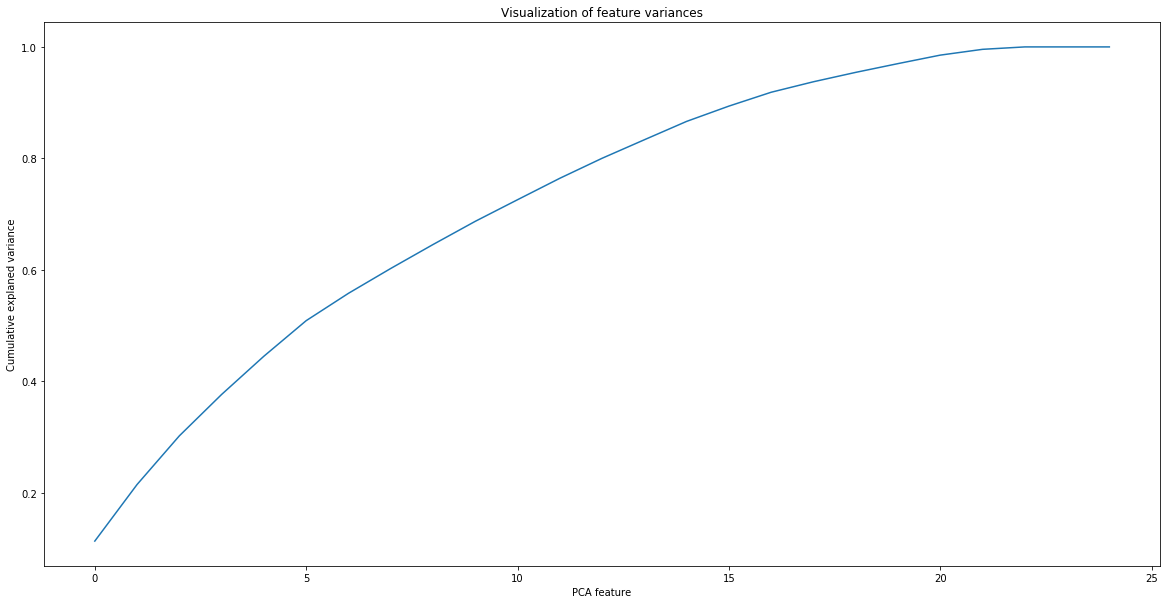

In [66]:
pca = PCA()
pca.fit(scaled_df_linear.drop('Weekly_Sales',axis=1))

#Graphing the data
plt.figure(figsize=(20,10))

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Visualization of feature variances')
plt.xlabel('PCA feature')
plt.ylabel('Cumulative explaned variance')
plt.show()

In [67]:
pca_features = pca.fit_transform(scaled_df_linear.drop('Weekly_Sales',axis=1))
pca_features_linear = pd.DataFrame(pca_features)
pca_features_linear['Weekly_Sales'] = df['Weekly_Sales']
pca_features_linear.to_csv(r'C:\Users\songs\Desktop\Springboard Files\Springboard-Files\Capstone 2\data\Interim\pca_train_linear.csv')
pca_features_linear.head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,Weekly_Sales
0,-0.752335,0.068117,0.970663,3.478323,-2.108176,0.321941,-0.491063,-0.774540,-0.328520,0.254814,...,-1.270536,0.531778,-0.173915,-0.354399,-0.899842,1.466349,-0.115129,0.003964,-8.756189e-14,87235.57
1,-0.549790,-0.933805,1.503068,1.954158,-2.275526,0.033691,-0.190576,0.369842,0.561588,-1.081586,...,-0.344002,-0.090741,0.275123,0.532742,-0.687657,0.177188,-0.016111,0.010096,1.236883e-13,80254.53
2,-0.461566,-1.037258,1.640471,1.588625,-2.295451,0.035476,0.086270,-0.417934,0.562711,1.292499,...,0.403864,-0.199976,0.400694,0.443014,-0.706355,-0.261634,-0.051205,-0.006041,-9.912919e-15,77715.58
3,-0.522906,-0.818632,1.669310,1.296223,-2.165385,-0.013559,-0.208960,-0.189112,1.190923,0.894515,...,0.216796,0.086552,0.372673,0.357901,-0.556076,-0.178644,-0.094264,-0.005139,-6.825293e-15,83599.56
4,-0.562801,-0.926086,1.493272,0.924735,-2.361050,0.124559,-0.102493,-1.020222,-0.451497,0.566600,...,0.575908,0.182986,0.439408,0.260756,-0.497150,-0.388944,-0.129134,-0.000446,-1.587492e-15,77876.10


#### Not Feature Selected

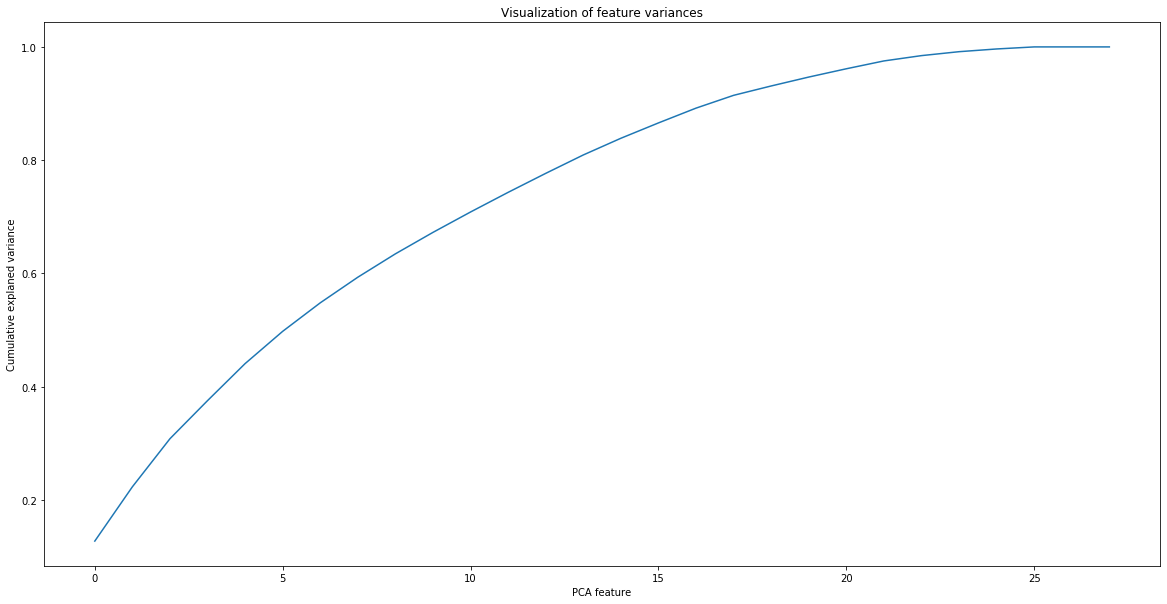

In [68]:
pca.fit(scaled_df.drop('Weekly_Sales',axis=1))

#Graphing the data
plt.figure(figsize=(20,10))

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Visualization of feature variances')
plt.xlabel('PCA feature')
plt.ylabel('Cumulative explaned variance')
plt.show()

In [69]:
pca_features = pca.fit_transform(scaled_df.drop('Weekly_Sales',axis=1))
pca_features_all = pd.DataFrame(pca_features)
pca_features_all['Weekly_Sales'] = df['Weekly_Sales']
pca_features_all.to_csv(r'C:\Users\songs\Desktop\Springboard Files\Springboard-Files\Capstone 2\data\Interim\pca_train_all.csv')
pca_features_all.head()

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,Weekly_Sales
0,-0.750720,0.968127,1.405234,-3.534053,-0.709929,0.114137,0.932270,1.211420,-0.664996,0.080213,...,-0.422060,0.230915,-0.590773,1.406542,0.615568,-0.114161,0.240652,0.003960,8.387638e-14,87235.57
1,-0.827327,0.257187,2.216137,-2.035985,-1.232567,-0.148951,0.972311,0.124215,0.259617,-0.249607,...,0.320014,-0.098852,-0.722737,0.074744,0.566277,-0.074426,0.131861,0.010103,-1.267414e-13,80254.53
2,-0.704417,0.161014,2.318746,-1.650940,-1.312254,-0.159641,0.683084,1.159147,-0.060412,1.360997,...,0.437736,0.030981,-0.715317,-0.348441,0.496988,-0.050472,0.155158,-0.006050,9.205646e-15,77715.58
3,-0.730341,0.351529,2.218119,-1.348977,-1.216232,-0.191023,0.879127,0.636738,-0.112127,1.518486,...,0.380818,0.057097,-0.544693,-0.264195,0.477929,-0.029389,0.192830,-0.005139,9.223192e-15,83599.56
4,-0.728031,0.239211,2.100961,-1.055872,-1.569517,-0.062887,0.678983,1.303062,-0.610465,0.248969,...,0.425938,0.153010,-0.461351,-0.464084,0.425401,-0.010880,0.217854,-0.000453,-2.143111e-15,77876.10


## Model creation:

First, let's read in our data which we processed above.

### Feature Selected (Linear, Ridge, and Lasso Regression)

In [3]:
scaled_df_fs = pd.read_csv(r'C:\Users\songs\Desktop\Springboard Files\Springboard-Files\Capstone 2\data\Interim\scaled_train_linear.csv',index_col=0)
pca_df_fs = pd.read_csv(r'C:\Users\songs\Desktop\Springboard Files\Springboard-Files\Capstone 2\data\Interim\pca_train_linear.csv',index_col=0)
original_df_fs = pd.read_csv(r'C:\Users\songs\Desktop\Springboard Files\Springboard-Files\Capstone 2\data\Interim\original_train_linear.csv',index_col=0)

In [6]:
original_df_fs = original_df_fs.drop('Diff_from_Med',axis=1)

### Not Feature Selected (RandomForestRegressor)

In [8]:
scaled_df = pd.read_csv(r'C:\Users\songs\Desktop\Springboard Files\Springboard-Files\Capstone 2\data\Interim\scaled_train.csv',index_col=0)
pca_df = pd.read_csv(r'C:\Users\songs\Desktop\Springboard Files\Springboard-Files\Capstone 2\data\Interim\pca_train_all.csv',index_col=0)
original_df = pd.read_csv(r'C:\Users\songs\Desktop\Springboard Files\Springboard-Files\Capstone 2\data\Interim\train_all_features.csv',index_col=0).drop('log_revenue',axis=1)

In [10]:
original_df = original_df.drop('Diff_from_Med',axis=1)

### Train test split

It's troublesome to create train_test_split for all 6 datasets, so I wrote a function that returns a tuple of 4. When it's time to use the train_test_split we can simply unpack them.

In [11]:
def create_train_test(data):
    X = data.drop(['Weekly_Sales'], axis=1).values
    y = data['Weekly_Sales'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    return X_train, X_test, y_train, y_test

### A hyperparameter optimizer.

RandomForest, as well as Lasso and Ridge Regression, have hyperparameters that need to be optimized for best performance. I wrote a function to expedite this process. All I need to input is the model, the hyperparameters tested in dictionary format, and the data to fit the model to.

In [58]:
#Writing a function to find best hyperparams
def optimize_params(model, params, data):
    """
    Select the best parameters out of a dict for a model given training data
    """
    #Train_test_split
    X = data.drop(['Weekly_Sales'], axis=1).values
    y = data['Weekly_Sales'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    #Search for best combination of hyperparameters from the dictionary
    reg = model()
    reg_cv = GridSearchCV(reg, param_grid=params, scoring='neg_mean_absolute_error',cv=5, verbose=10)
    reg_cv.fit(X_train, y_train)
    print(reg_cv.best_params_)

## Linear Regression

The process goes as follows: each dataset is put through the create_test_split function created above, cross-validated after fitting, and the results are saved and plotted in a bar graph. If there's anything interesting, they'll be noted later.

#### Scaled

In [17]:
#Create LinearRegression Model
linear = LinearRegression()

#Create training and testing split
X_train, X_test, y_train, y_test = create_train_test(scaled_df_fs)

#Fit and cross-validate
linear.fit(X_train, y_train)
scaled_results = cross_val_score(linear,X_test,y_test,scoring='neg_mean_absolute_error',cv=5)

#### PCA

In [18]:
#Create training and testing split
X_train, X_test, y_train, y_test = create_train_test(pca_df_fs)

#Fit and cross-validate
linear.fit(X_train, y_train)
pca_results = cross_val_score(linear,X_test,y_test,scoring='neg_mean_absolute_error',cv=5)

#### Original Dataset

In [19]:
#Create training and testing split
X_train, X_test, y_train, y_test = create_train_test(original_df_fs)

#Fit and cross-validate
linear.fit(X_train, y_train)
original_results = cross_val_score(linear,X_test,y_test,scoring='neg_mean_absolute_error',cv=5)

Then, after getting the scores, we find the mean and standard deviation. Since the scoring is negative mean absolute error, I will multiply the means by -1 to get the MAE and plot them with their standard deviations in a bar plot.

In [20]:
means = [np.mean(scaled_results)*-1, np.mean(pca_results)*-1, np.mean(original_results)*-1]
stds = [np.std(scaled_results),np.std(pca_results),np.std(original_results)]

#### Graphing

[15142.177875069572, 15201.749481537516, 2216.682615020744]
[77.4960999629544, 68.50068698533876, 37.521836903394735]


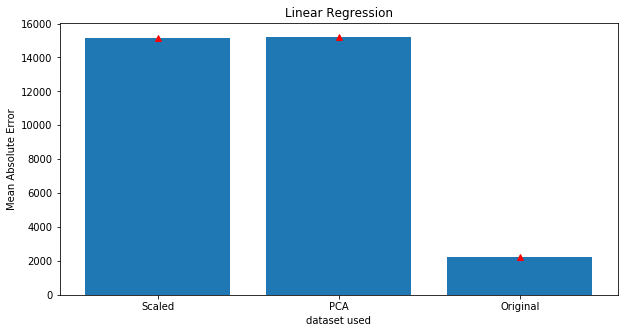

In [21]:
plt.figure(figsize=(10,5))

#Data
plt.bar(range(3),means)
plt.errorbar(range(3), means, stds, linestyle='None', marker='^',color='red')
plt.xlabel("dataset used")
plt.xticks(range(3),['Scaled','PCA','Original'])
plt.ylabel("Mean Absolute Error")
plt.title("Linear Regression")

print(means)
print(stds)

It appears that the original dataset performs the best (has the lowest MAE) for Linear Regression. 

### Ridge Regression

For Ridge and Lasso Regression, we need to first search for the best value of alpha. 

In [176]:
model = Ridge
params_to_test = {'alpha':np.arange(0.0001, 0.001, 0.0001)}

optimize_params(model, params_to_test, scaled_df)
optimize_params(model, params_to_test, pca_df)
optimize_params(model, params_to_test, original_df)

{'alpha': 0.0009000000000000001}
{'alpha': 0.0001}


C:\Users\songs\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.404e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\songs\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=7.67656e-18): result may not be accurate.
  overwrite_a=True).T
C:\Users\songs\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.67088e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\songs\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.35871e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\songs\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.58192e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\songs\Anaconda3\lib\site-packages\sklearn\linear_model\rid

{'alpha': 0.0009000000000000001}


Using the alphas found above, we create our models. After creating the models, we find the mean negative absolute error, multiple it by -1, and graph it in a bar plot with the standard deviation just like we've done before.

#### Scaled

In [34]:
#Create Ridge Regression Model
ridge = Ridge(alpha=0.0009)

#Create training and testing split
X_train, X_test, y_train, y_test = create_train_test(scaled_df_fs)

#Fit and cross-validate
ridge.fit(X_train, y_train)
scaled_results = cross_val_score(ridge,X_test,y_test,scoring='neg_mean_absolute_error',cv=5)

#### PCA

In [35]:
#Create Ridge Regression Model
ridge = Ridge(alpha=0.0001)

#Create training and testing split
X_train, X_test, y_train, y_test = create_train_test(pca_df_fs)

#Fit and cross-validate
ridge.fit(X_train, y_train)
pca_results = cross_val_score(ridge,X_test,y_test,scoring='neg_mean_absolute_error',cv=5)

#### Original Dataset

In [36]:
#Create Ridge Regression Model
ridge = Ridge(alpha=0.0009)

#Create training and testing split
X_train, X_test, y_train, y_test = create_train_test(original_df_fs)

#Fit and cross-validate
ridge.fit(X_train, y_train)
scaled_results = cross_val_score(ridge,X_test,y_test,scoring='neg_mean_absolute_error',cv=5)

In [37]:
#Graphing
means = [np.mean(scaled_results)*-1, np.mean(pca_results)*-1, np.mean(original_results)*-1]
stds = [np.std(scaled_results),np.std(pca_results),np.std(original_results)]

[2222.312444920872, 15140.293480872127, 2216.682615020744]
[28.421385214636818, 112.48004886883169, 37.521836903394735]


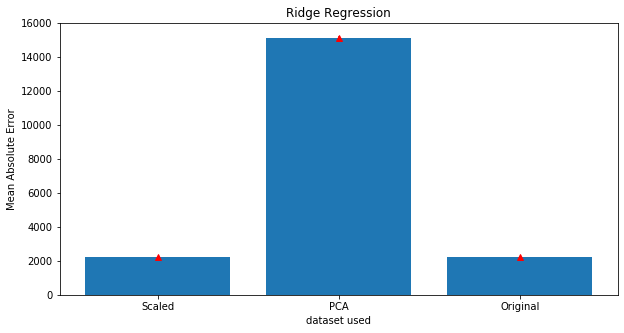

In [38]:
plt.figure(figsize=(10,5))
plt.bar(range(3),means)
plt.errorbar(range(3), means, stds, linestyle='None', marker='^',color='red')
plt.xlabel("dataset used")
plt.xticks(range(3),['Scaled','PCA','Original'])
plt.ylabel("Mean Absolute Error")
plt.title("Ridge Regression")

print(means)
print(stds)

### Lasso

Similar to Ridge Regression, I first optimized the alpha value before fitting the models and getting the MAE.

In [196]:
model = Lasso
params_to_test = {'alpha':np.arange(0.00001, 0.0001, 0.00001)}

optimize_params(model, params_to_test, scaled_df)
optimize_params(model, params_to_test, pca_df)
optimize_params(model, params_to_test, original_df)

{'alpha': 0.0001}
{'alpha': 0.0001}
{'alpha': 0.0009}


#### Scaled

In [191]:
#Create Model
lasso = Lasso(alpha=0.0001)

#Create training and testing split
X_train, X_test, y_train, y_test = create_train_test(scaled_df_fs)

#Fit and cross-validate
lasso.fit(X_train, y_train)
scaled_results = cross_val_score(lasso,X_test,y_test,scoring='neg_mean_absolute_error',cv=5)

C:\Users\songs\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 50326269930939.086, tolerance: 10077125689.496344
  positive)
C:\Users\songs\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17427602356375.768, tolerance: 3500288922.2857084
  positive)
C:\Users\songs\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 17729792985201.53, tolerance: 3556634249.6644244
  positive)
C:\Users\songs\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality 

#### PCA

In [192]:
#Create Model
lasso = Lasso(alpha=0.0001)

#Create training and testing split
X_train, X_test, y_train, y_test = create_train_test(pca_df_fs)

#Fit and cross-validate
lasso.fit(X_train, y_train)
scaled_results = cross_val_score(lasso,X_test,y_test,scoring='neg_mean_absolute_error',cv=5)

#### Original Dataset

In [193]:
#Create Model
lasso = Lasso(alpha=0.0009)

#Create training and testing split
X_train, X_test, y_train, y_test = create_train_test(original_df_fs)

#Fit and cross-validate
lasso.fit(X_train, y_train)
scaled_results = cross_val_score(lasso,X_test,y_test,scoring='neg_mean_absolute_error',cv=5)

C:\Users\songs\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3752822436610.8003, tolerance: 10089503149.793413
  positive)
C:\Users\songs\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1401619302052.6838, tolerance: 3576068381.6816463
  positive)
C:\Users\songs\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1356970734625.3748, tolerance: 3545127825.465794
  positive)
C:\Users\songs\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality 

Below is the plot of MAE with standard deviation.

In [194]:
means = [np.mean(scaled_results)*-1, np.mean(pca_results)*-1, np.mean(original_results)*-1]
stds = [np.std(scaled_results),np.std(pca_results),np.std(original_results)]

[2227.323491948231, 15188.47529584504, 2226.093735693712]
[37.07224084555823, 102.92823676953664, 17.547364843849518]


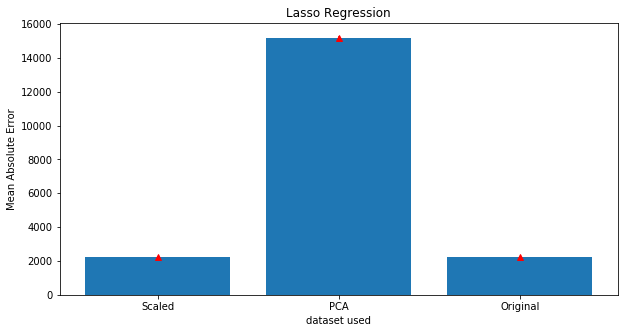

In [198]:
plt.figure(figsize=(10,5))
plt.bar(range(3),means)
plt.errorbar(range(3), means, stds, linestyle='None', marker='^',color='red')
plt.xlabel("dataset used")
plt.xticks(range(3),['Scaled','PCA','Original'])
plt.ylabel("Mean Absolute Error")
plt.title("Lasso Regression")

print(means)
print(stds)

### RandomForestRegressor

I tested for the optimal number of trees ("n_estimators") because that is the most important hyperparameter to tune. 

In [197]:
model = RandomForestRegressor
params_to_test = {'n_estimators':[5,10,20,30,40,50,75,100]}

optimize_params(model, params_to_test, scaled_df)
optimize_params(model, params_to_test, pca_df)
optimize_params(model, params_to_test, original_df)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] n_estimators=5 ..................................................
[CV] .................. n_estimators=5, score=-6741.739, total=   9.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.4s remaining:    0.0s


[CV] n_estimators=5 ..................................................
[CV] .................. n_estimators=5, score=-6661.348, total=   9.6s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   19.0s remaining:    0.0s


[CV] n_estimators=5 ..................................................
[CV] .................. n_estimators=5, score=-6842.757, total=   9.7s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   28.7s remaining:    0.0s


[CV] n_estimators=5 ..................................................
[CV] .................. n_estimators=5, score=-6879.903, total=   9.3s


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   38.0s remaining:    0.0s


[CV] n_estimators=5 ..................................................
[CV] .................. n_estimators=5, score=-6755.881, total=   9.9s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   47.9s remaining:    0.0s


[CV] n_estimators=10 .................................................
[CV] ................. n_estimators=10, score=-6520.731, total=  19.5s


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.1min remaining:    0.0s


[CV] n_estimators=10 .................................................
[CV] ................. n_estimators=10, score=-6369.295, total=  19.2s


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.4min remaining:    0.0s


[CV] n_estimators=10 .................................................
[CV] ................. n_estimators=10, score=-6505.843, total=  18.9s


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.8min remaining:    0.0s


[CV] n_estimators=10 .................................................
[CV] ................. n_estimators=10, score=-6398.961, total=  18.7s


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  2.1min remaining:    0.0s


[CV] n_estimators=10 .................................................
[CV] ................. n_estimators=10, score=-6517.407, total=  19.6s
[CV] n_estimators=20 .................................................
[CV] ................. n_estimators=20, score=-6107.125, total=  39.2s
[CV] n_estimators=20 .................................................
[CV] ................. n_estimators=20, score=-6169.894, total=  40.5s
[CV] n_estimators=20 .................................................
[CV] ................. n_estimators=20, score=-6176.500, total=  38.2s
[CV] n_estimators=20 .................................................
[CV] ................. n_estimators=20, score=-6253.987, total=  37.9s
[CV] n_estimators=20 .................................................
[CV] ................. n_estimators=20, score=-6142.646, total=  39.8s
[CV] n_estimators=30 .................................................
[CV] ................. n_estimators=30, score=-6098.287, total=  56.3s
[CV] n

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 52.8min finished


{'n_estimators': 100}
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] n_estimators=5 ..................................................
[CV] ................. n_estimators=5, score=-17095.711, total=  39.8s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   39.7s remaining:    0.0s


[CV] n_estimators=5 ..................................................
[CV] ................. n_estimators=5, score=-17310.972, total=  38.8s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.3min remaining:    0.0s


[CV] n_estimators=5 ..................................................
[CV] ................. n_estimators=5, score=-17237.167, total=  39.5s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.0min remaining:    0.0s


[CV] n_estimators=5 ..................................................
[CV] ................. n_estimators=5, score=-17236.810, total=  41.3s


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.7min remaining:    0.0s


[CV] n_estimators=5 ..................................................
[CV] ................. n_estimators=5, score=-17282.369, total=  42.5s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.4min remaining:    0.0s


[CV] n_estimators=10 .................................................
[CV] ................ n_estimators=10, score=-16552.792, total= 1.4min


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  4.7min remaining:    0.0s


[CV] n_estimators=10 .................................................
[CV] ................ n_estimators=10, score=-16642.187, total= 1.3min


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  6.0min remaining:    0.0s


[CV] n_estimators=10 .................................................
[CV] ................ n_estimators=10, score=-16667.010, total= 1.3min


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  7.3min remaining:    0.0s


[CV] n_estimators=10 .................................................
[CV] ................ n_estimators=10, score=-16694.292, total= 1.4min


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  8.7min remaining:    0.0s


[CV] n_estimators=10 .................................................
[CV] ................ n_estimators=10, score=-16670.625, total= 1.4min
[CV] n_estimators=20 .................................................
[CV] ................ n_estimators=20, score=-16190.061, total= 2.7min
[CV] n_estimators=20 .................................................
[CV] ................ n_estimators=20, score=-16326.061, total= 2.7min
[CV] n_estimators=20 .................................................
[CV] ................ n_estimators=20, score=-16319.006, total= 2.6min
[CV] n_estimators=20 .................................................
[CV] ................ n_estimators=20, score=-16360.258, total= 2.6min
[CV] n_estimators=20 .................................................
[CV] ................ n_estimators=20, score=-16232.393, total= 2.8min
[CV] n_estimators=30 .................................................
[CV] ................ n_estimators=30, score=-16072.712, total= 4.1min
[CV] n

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 220.8min finished


{'n_estimators': 100}
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] n_estimators=5 ..................................................
[CV] ..................... n_estimators=5, score=-4.945, total=   8.7s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.7s remaining:    0.0s


[CV] n_estimators=5 ..................................................
[CV] .................... n_estimators=5, score=-10.858, total=   8.7s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   17.5s remaining:    0.0s


[CV] n_estimators=5 ..................................................
[CV] ..................... n_estimators=5, score=-2.472, total=   8.7s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   26.2s remaining:    0.0s


[CV] n_estimators=5 ..................................................
[CV] ..................... n_estimators=5, score=-4.171, total=   8.7s


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   35.0s remaining:    0.0s


[CV] n_estimators=5 ..................................................
[CV] ..................... n_estimators=5, score=-2.863, total=   8.7s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   43.8s remaining:    0.0s


[CV] n_estimators=10 .................................................
[CV] .................... n_estimators=10, score=-3.312, total=  17.0s


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.0min remaining:    0.0s


[CV] n_estimators=10 .................................................
[CV] .................... n_estimators=10, score=-8.170, total=  17.0s


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.3min remaining:    0.0s


[CV] n_estimators=10 .................................................
[CV] .................... n_estimators=10, score=-3.148, total=  17.0s


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.6min remaining:    0.0s


[CV] n_estimators=10 .................................................
[CV] .................... n_estimators=10, score=-3.653, total=  17.1s


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.9min remaining:    0.0s


[CV] n_estimators=10 .................................................
[CV] .................... n_estimators=10, score=-3.272, total=  17.1s
[CV] n_estimators=20 .................................................
[CV] .................... n_estimators=20, score=-7.429, total=  33.7s
[CV] n_estimators=20 .................................................
[CV] .................... n_estimators=20, score=-7.729, total=  33.7s
[CV] n_estimators=20 .................................................
[CV] .................... n_estimators=20, score=-3.349, total=  33.7s
[CV] n_estimators=20 .................................................
[CV] .................... n_estimators=20, score=-3.785, total=  33.5s
[CV] n_estimators=20 .................................................
[CV] .................... n_estimators=20, score=-2.346, total=  33.7s
[CV] n_estimators=30 .................................................
[CV] .................... n_estimators=30, score=-6.810, total=  50.3s
[CV] n

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 46.0min finished


{'n_estimators': 75}


#### Scaled

In [41]:
#Create RandomForest Model
rf = RandomForestRegressor(n_estimators=100)

#Create training and testing split
X_train, X_test, y_train, y_test = create_train_test(scaled_df)

#Fit and cross-validate
rf.fit(X_train, y_train)
scaled_results = cross_val_score(rf,X_test,y_test,scoring='neg_mean_absolute_error',cv=5)

#### PCA

In [42]:
#Create Model
rf = RandomForestRegressor(n_estimators=100)

#Create training and testing split
X_train, X_test, y_train, y_test = create_train_test(pca_df)

#Fit and cross-validate
rf.fit(X_train, y_train)
scaled_results = cross_val_score(rf,X_test,y_test,scoring='neg_mean_absolute_error',cv=5)

#### Original Dataset

In [43]:
#Create Model
rf = RandomForestRegressor(n_estimators=75)

#Create training and testing split
X_train, X_test, y_train, y_test = create_train_test(original_df)

#Fit and cross-validate
rf.fit(X_train, y_train)
scaled_results = cross_val_score(rf,X_test,y_test,scoring='neg_mean_absolute_error',cv=5)

In [44]:
means = [np.mean(scaled_results)*-1, np.mean(pca_results)*-1, np.mean(original_results)*-1]
stds = [np.std(scaled_results),np.std(pca_results),np.std(original_results)]

[1937.9185534462345, 15140.293480872127, 2216.682615020744]
[30.43682739007503, 112.48004886883169, 37.521836903394735]


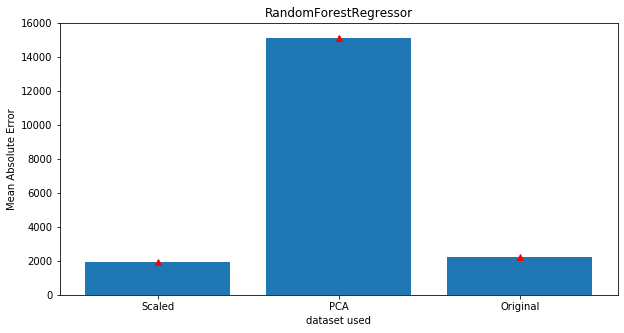

In [45]:
plt.figure(figsize=(10,5))
plt.bar(range(3),means)
plt.errorbar(range(3), means, stds, linestyle='None', marker='^',color='red')
plt.xlabel("dataset used")
plt.xticks(range(3),['Scaled','PCA','Original'])
plt.ylabel("Mean Absolute Error")
plt.title("RandomForestRegressor")

print(means)
print(stds)

Now, let's look at the feature importance of the last RandomForestRegressor model.

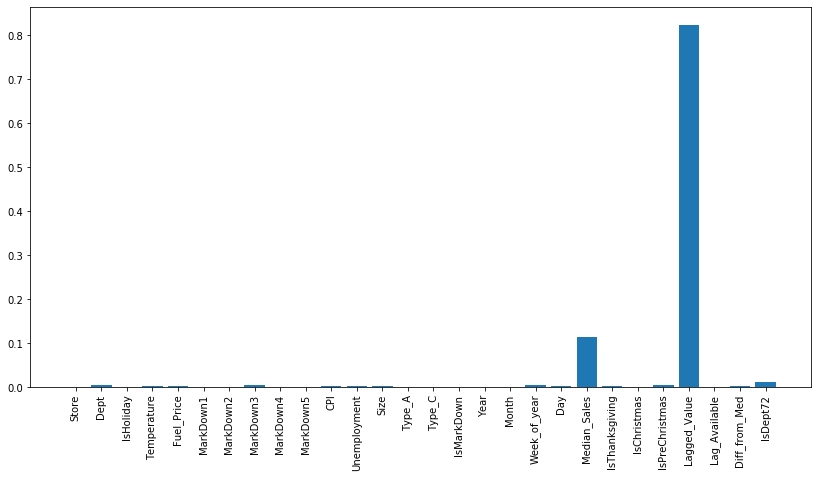

In [216]:
plt.figure(figsize=(14,7))
plt.bar(range(len(rf.feature_importances_)),rf.feature_importances_)
plt.xticks(range(len(rf.feature_importances_)),original_df.drop('Weekly_Sales',axis=1).columns,rotation=90)
plt.show()

#### XGBoost

In [51]:
from xgboost import XGBRegressor

#### Scaled

In [52]:
#Create RandomForest Model
xgb = XGBRegressor()

#Create training and testing split
X_train, X_test, y_train, y_test = create_train_test(scaled_df)

#Fit and cross-validate
xgb.fit(X_train, y_train)
scaled_results = cross_val_score(xgb,X_test,y_test,scoring='neg_mean_absolute_error',cv=5)

[22:46:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:46:25] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:46:29] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:46:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:46:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:46:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


#### PCA

In [53]:
#Create Model
xgb = XGBRegressor()

#Create training and testing split
X_train, X_test, y_train, y_test = create_train_test(pca_df)

#Fit and cross-validate
xgb.fit(X_train, y_train)
scaled_results = cross_val_score(xgb,X_test,y_test,scoring='neg_mean_absolute_error',cv=5)

[22:47:19] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:47:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:47:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:48:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:48:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:48:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


#### Original Dataset

In [54]:
#Create Model
xgb = XGBRegressor()

#Create training and testing split
X_train, X_test, y_train, y_test = create_train_test(original_df)

#Fit and cross-validate
xgb.fit(X_train, y_train)
scaled_results = cross_val_score(xgb,X_test,y_test,scoring='neg_mean_absolute_error',cv=5)

[22:48:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:48:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:48:52] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:48:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:49:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:49:04] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [55]:
means = [np.mean(scaled_results)*-1, np.mean(pca_results)*-1, np.mean(original_results)*-1]
stds = [np.std(scaled_results),np.std(pca_results),np.std(original_results)]

[1992.6614106697562, 15140.293480872127, 2216.682615020744]
[41.69749559509363, 112.48004886883169, 37.521836903394735]


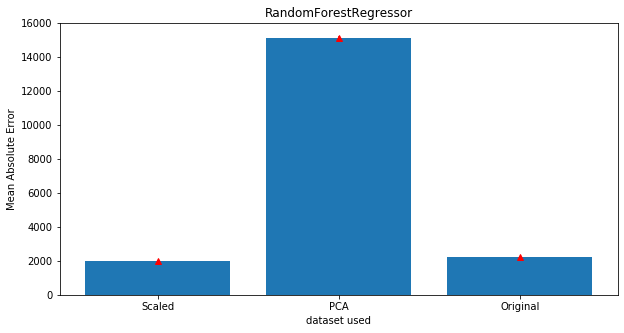

In [56]:
plt.figure(figsize=(10,5))
plt.bar(range(3),means)
plt.errorbar(range(3), means, stds, linestyle='None', marker='^',color='red')
plt.xlabel("dataset used")
plt.xticks(range(3),['Scaled','PCA','Original'])
plt.ylabel("Mean Absolute Error")
plt.title("RandomForestRegressor")

print(means)
print(stds)

### SVR

In [57]:
from sklearn.svm import SVR

In [ ]:
model = SVR
params_to_test = {'C':np.arange(0.1, 1, 0.1),'kernel':['linear', 'rbf']}

optimize_params(model, params_to_test, scaled_df)
optimize_params(model, params_to_test, pca_df)
optimize_params(model, params_to_test, original_df)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] C=0.1, kernel=linear ............................................
[CV] ........... C=0.1, kernel=linear, score=-13414.477, total=37.5min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 37.5min remaining:    0.0s


[CV] C=0.1, kernel=linear ............................................
[CV] ........... C=0.1, kernel=linear, score=-13330.719, total=36.4min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 73.8min remaining:    0.0s


[CV] C=0.1, kernel=linear ............................................
[CV] ........... C=0.1, kernel=linear, score=-13552.369, total=17.6min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 91.5min remaining:    0.0s


[CV] C=0.1, kernel=linear ............................................
[CV] ........... C=0.1, kernel=linear, score=-13275.998, total=34.0min


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 125.4min remaining:    0.0s


[CV] C=0.1, kernel=linear ............................................
[CV] ........... C=0.1, kernel=linear, score=-13401.183, total=17.9min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 143.3min remaining:    0.0s


[CV] C=0.1, kernel=rbf ...............................................


C:\Users\songs\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[CV] .............. C=0.1, kernel=rbf, score=-13423.796, total=25.0min


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 168.3min remaining:    0.0s


[CV] C=0.1, kernel=rbf ...............................................


C:\Users\songs\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[CV] .............. C=0.1, kernel=rbf, score=-13340.348, total=24.9min


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 193.2min remaining:    0.0s


[CV] C=0.1, kernel=rbf ...............................................


C:\Users\songs\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[CV] .............. C=0.1, kernel=rbf, score=-13561.650, total=24.9min


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 218.1min remaining:    0.0s


[CV] C=0.1, kernel=rbf ...............................................


C:\Users\songs\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[CV] ............. C=0.1, kernel=rbf, score=-13284.596, total=793.2min


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 1011.3min remaining:    0.0s


[CV] C=0.1, kernel=rbf ...............................................


C:\Users\songs\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[CV] .............. C=0.1, kernel=rbf, score=-13410.574, total=71.1min
[CV] C=0.2, kernel=linear ............................................
[CV] ........... C=0.2, kernel=linear, score=-13412.361, total=34.5min
[CV] C=0.2, kernel=linear ............................................
[CV] ........... C=0.2, kernel=linear, score=-13328.901, total=18.1min
[CV] C=0.2, kernel=linear ............................................
[CV] ........... C=0.2, kernel=linear, score=-13550.004, total=17.7min
[CV] C=0.2, kernel=linear ............................................
[CV] ........... C=0.2, kernel=linear, score=-13274.483, total=33.2min
[CV] C=0.2, kernel=linear ............................................
[CV] .......... C=0.2, kernel=linear, score=-13398.665, total=388.3min
[CV] C=0.2, kernel=rbf ...............................................


C:\Users\songs\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[CV] .............. C=0.2, kernel=rbf, score=-13423.255, total=61.0min
[CV] C=0.2, kernel=rbf ...............................................


C:\Users\songs\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[CV] .............. C=0.2, kernel=rbf, score=-13339.679, total=26.3min
[CV] C=0.2, kernel=rbf ...............................................


C:\Users\songs\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[CV] .............. C=0.2, kernel=rbf, score=-13561.077, total=26.6min
[CV] C=0.2, kernel=rbf ...............................................


C:\Users\songs\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[CV] .............. C=0.2, kernel=rbf, score=-13284.007, total=26.3min
[CV] C=0.2, kernel=rbf ...............................................


C:\Users\songs\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[CV] .............. C=0.2, kernel=rbf, score=-13410.016, total=28.4min
[CV] C=0.30000000000000004, kernel=linear ............................
[CV]  C=0.30000000000000004, kernel=linear, score=-13411.540, total=33.3min
[CV] C=0.30000000000000004, kernel=linear ............................
[CV]  C=0.30000000000000004, kernel=linear, score=-13328.134, total=33.0min
[CV] C=0.30000000000000004, kernel=linear ............................
[CV]  C=0.30000000000000004, kernel=linear, score=-13548.843, total=33.2min
[CV] C=0.30000000000000004, kernel=linear ............................
[CV]  C=0.30000000000000004, kernel=linear, score=-13273.824, total=33.3min
[CV] C=0.30000000000000004, kernel=linear ............................
[CV]  C=0.30000000000000004, kernel=linear, score=-13397.393, total=33.2min
[CV] C=0.30000000000000004, kernel=rbf ...............................


C:\Users\songs\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[CV]  C=0.30000000000000004, kernel=rbf, score=-13422.726, total=25.0min
[CV] C=0.30000000000000004, kernel=rbf ...............................


C:\Users\songs\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[CV]  C=0.30000000000000004, kernel=rbf, score=-13339.055, total=25.0min
[CV] C=0.30000000000000004, kernel=rbf ...............................


C:\Users\songs\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[CV]  C=0.30000000000000004, kernel=rbf, score=-13560.538, total=25.0min
[CV] C=0.30000000000000004, kernel=rbf ...............................


C:\Users\songs\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[CV]  C=0.30000000000000004, kernel=rbf, score=-13283.451, total=25.0min
[CV] C=0.30000000000000004, kernel=rbf ...............................


C:\Users\songs\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[CV]  C=0.30000000000000004, kernel=rbf, score=-13409.485, total=25.0min
[CV] C=0.4, kernel=linear ............................................
[CV] ........... C=0.4, kernel=linear, score=-13411.137, total=33.1min
[CV] C=0.4, kernel=linear ............................................
[CV] ........... C=0.4, kernel=linear, score=-13327.765, total=33.2min
[CV] C=0.4, kernel=linear ............................................
[CV] ........... C=0.4, kernel=linear, score=-13548.229, total=33.4min
[CV] C=0.4, kernel=linear ............................................
[CV] ........... C=0.4, kernel=linear, score=-13273.484, total=33.3min
[CV] C=0.4, kernel=linear ............................................
[CV] ........... C=0.4, kernel=linear, score=-13396.675, total=17.3min
[CV] C=0.4, kernel=rbf ...............................................


C:\Users\songs\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[CV] .............. C=0.4, kernel=rbf, score=-13422.228, total=25.0min
[CV] C=0.4, kernel=rbf ...............................................


C:\Users\songs\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[CV] .............. C=0.4, kernel=rbf, score=-13338.453, total=25.0min
[CV] C=0.4, kernel=rbf ...............................................


C:\Users\songs\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[CV] .............. C=0.4, kernel=rbf, score=-13560.012, total=25.0min
[CV] C=0.4, kernel=rbf ...............................................


C:\Users\songs\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[CV] .............. C=0.4, kernel=rbf, score=-13282.930, total=25.0min
[CV] C=0.4, kernel=rbf ...............................................


C:\Users\songs\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[CV] .............. C=0.4, kernel=rbf, score=-13408.986, total=25.0min
[CV] C=0.5, kernel=linear ............................................
[CV] ........... C=0.5, kernel=linear, score=-13410.886, total=33.2min
[CV] C=0.5, kernel=linear ............................................
[CV] ........... C=0.5, kernel=linear, score=-13327.473, total=17.4min
[CV] C=0.5, kernel=linear ............................................
[CV] ........... C=0.5, kernel=linear, score=-13547.841, total=33.4min
[CV] C=0.5, kernel=linear ............................................
[CV] ........... C=0.5, kernel=linear, score=-13273.333, total=18.3min
[CV] C=0.5, kernel=linear ............................................
[CV] ........... C=0.5, kernel=linear, score=-13396.239, total=35.1min
[CV] C=0.5, kernel=rbf ...............................................


C:\Users\songs\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[CV] .............. C=0.5, kernel=rbf, score=-13421.745, total=26.2min
[CV] C=0.5, kernel=rbf ...............................................


C:\Users\songs\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[CV] .............. C=0.5, kernel=rbf, score=-13337.893, total=25.2min
[CV] C=0.5, kernel=rbf ...............................................


C:\Users\songs\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[CV] .............. C=0.5, kernel=rbf, score=-13559.525, total=25.3min
[CV] C=0.5, kernel=rbf ...............................................


C:\Users\songs\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[CV] .............. C=0.5, kernel=rbf, score=-13282.434, total=25.7min
[CV] C=0.5, kernel=rbf ...............................................


C:\Users\songs\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[CV] .............. C=0.5, kernel=rbf, score=-13408.496, total=25.7min
[CV] C=0.6, kernel=linear ............................................
[CV] ........... C=0.6, kernel=linear, score=-13410.750, total=17.5min
[CV] C=0.6, kernel=linear ............................................
[CV] ........... C=0.6, kernel=linear, score=-13327.354, total=17.4min
[CV] C=0.6, kernel=linear ............................................
[CV] ........... C=0.6, kernel=linear, score=-13547.608, total=18.1min
[CV] C=0.6, kernel=linear ............................................
[CV] ........... C=0.6, kernel=linear, score=-13273.324, total=34.7min
[CV] C=0.6, kernel=linear ............................................
[CV] ........... C=0.6, kernel=linear, score=-13395.907, total=34.5min
[CV] C=0.6, kernel=rbf ...............................................


C:\Users\songs\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[CV] .............. C=0.6, kernel=rbf, score=-13421.289, total=26.2min
[CV] C=0.6, kernel=rbf ...............................................


C:\Users\songs\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[CV] .............. C=0.6, kernel=rbf, score=-13337.355, total=26.7min
[CV] C=0.6, kernel=rbf ...............................................


C:\Users\songs\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[CV] .............. C=0.6, kernel=rbf, score=-13559.061, total=25.9min
[CV] C=0.6, kernel=rbf ...............................................


C:\Users\songs\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[CV] .............. C=0.6, kernel=rbf, score=-13281.964, total=26.1min
[CV] C=0.6, kernel=rbf ...............................................


C:\Users\songs\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[CV] .............. C=0.6, kernel=rbf, score=-13408.034, total=26.2min
[CV] C=0.7000000000000001, kernel=linear .............................
[CV]  C=0.7000000000000001, kernel=linear, score=-13410.632, total=19.2min
[CV] C=0.7000000000000001, kernel=linear .............................
[CV]  C=0.7000000000000001, kernel=linear, score=-13327.356, total=17.9min
[CV] C=0.7000000000000001, kernel=linear .............................
[CV]  C=0.7000000000000001, kernel=linear, score=-13547.412, total=17.9min
[CV] C=0.7000000000000001, kernel=linear .............................
